# Instalar e importar bibliotecas y librerías necesarias

In [22]:
import torch
import torch.nn as nn
from datasets import ClassLabel
import numpy as np
import torchvision.transforms as transforms
import pandas as pd

In [23]:
torch.cuda.is_available()

True

In [24]:
from datasets import Image as dsImage, Dataset

In [25]:
from evaluate import load as load_metric
from transformers import AutoFeatureExtractor, AutoImageProcessor, SwinForImageClassification
from transformers import AutoModelForImageClassification, TrainingArguments, Trainer
from PIL import Image, ImageFile
from pathlib import Path
ImageFile.LOAD_TRUNCATED_IMAGES = True #imagenes ligeramente corruptas OK
import requests

# Datos

In [34]:
import os

# Ruta al directorio que contiene las imágenes
rootdir = "images/2023/"

# Lista para almacenar las rutas de las imágenes
image_paths = []

# Iterar sobre los archivos en el directorio
for directory in os.listdir(rootdir):
    for filename in os.listdir(rootdir+"/"+directory):
        # Verificar si el archivo es una imagen (puedes agregar más extensiones según sea necesario)
        if filename.endswith(".jpg") or filename.endswith(".jpeg") or filename.endswith(".png"):
            # Construir la ruta completa del archivo
            image_path = os.path.join(directory, filename)
            # Agregar la ruta del archivo a la lista
            image_paths.append(image_path)

In [35]:
# Crear un DataFrame con las rutas de las imágenes
data = pd.DataFrame({
    "Path": image_paths,
    # Añade más columnas si necesitas incluir más información sobre las imágenes
})

# Muestra el DataFrame
data

,Path
0,abr/p0401231.jpg
1,abr/p0401232.jpg
2,abr/p0402231.jpg
3,abr/p0402232.jpg
4,abr/p0402233.jpg
...,...
637,may/p0510231.jpg
638,may/p0506233.jpg
639,may/p0510232.jpg
640,may/p0514232.jpg


In [7]:
data = pd.read_feather("NN_INPUT.feather"); #Dataset

drop=[]
for i,r in data.iterrows():
    if not Path(f"images/{r['Path']}").exists():
        drop.append(i)

data.drop(drop,inplace=True)


data

,Path,FUM,EXP,INAC
0,2000/abr/p0423001.jpg,0.0,0.0,1.0
1,2000/abr/p0423002.jpg,1.0,0.0,0.0
2,2000/abr/p0423003.jpg,1.0,0.0,0.0
3,2000/abr/p0424001.jpg,1.0,0.0,0.0
4,2000/abr/p0424002.jpg,1.0,0.0,0.0
...,...,...,...,...
21926,2023/mar/p0316234.jpeg,1.0,0.0,0.0
21927,2023/mar/p0317231.jpeg,1.0,1.0,0.0
21928,2023/mar/p0317232.jpeg,1.0,1.0,0.0
21929,2023/mar/p0317233.jpeg,1.0,1.0,0.0


# Dataset

In [79]:
def GEN():
    for i,r in data.iterrows():
        I,F,E,N=r
        L="UNK"
        if F>0:
            if E>0:
                L="EXP+FUM"
            else:
                L="FUM"
        elif E>0:
            L="EXP"
        elif N>0:
            L="INA"
        yield {
            "image":f"images/{I}",
            "label":L,
            "orig_id":i
        }
Data=Dataset.from_generator(GEN)
Data=Data.cast_column("image",dsImage()).cast_column("label",ClassLabel(names=["UNK","EXP","FUM","EXP+FUM","INA"]))

Generating train split: 0 examples [00:00, ? examples/s]

Casting the dataset:   0%|          | 0/21921 [00:00<?, ? examples/s]

In [80]:
labels = Data.features["label"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = i
    id2label[i] = label

id2label[2]

'FUM'

In [81]:
Data=Data.train_test_split(.05, seed=36918)

In [82]:
Data

DatasetDict({
    train: Dataset({
        features: ['image', 'label', 'orig_id'],
        num_rows: 20824
    })
    test: Dataset({
        features: ['image', 'label', 'orig_id'],
        num_rows: 1097
    })
})

In [83]:
Data["train"][0]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x480>,
 'label': 2,
 'orig_id': 2876}

In [84]:
Data["train"][0]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x480>,
 'label': 2,
 'orig_id': 2876}

# Modelo

In [85]:
model_name="microsoft/swinv2-base-patch4-window16-256"

In [86]:
image_processor = AutoImageProcessor.from_pretrained(model_name)

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


In [87]:
from torchvision.transforms import (
    CenterCrop,
    Compose,
    Normalize,
    RandomHorizontalFlip,
    RandomResizedCrop,
    Resize,
    ToTensor,
)

normalize = Normalize(mean=image_processor.image_mean, std=image_processor.image_std)
if "height" in image_processor.size:
    size = (image_processor.size["height"], image_processor.size["width"])
    crop_size = size
    max_size = None
elif "shortest_edge" in image_processor.size:
    size = image_processor.size["shortest_edge"]
    crop_size = (size, size)
    max_size = image_processor.size.get("longest_edge")

train_transforms = Compose(
        [
            RandomResizedCrop(crop_size),
            RandomHorizontalFlip(),
            ToTensor(),
            normalize,
        ]
    )

val_transforms = Compose(
        [
            Resize(size),
            CenterCrop(crop_size),
            ToTensor(),
            normalize,
        ]
    )

def preprocess_train(example_batch):
    """Apply train_transforms across a batch."""
    example_batch["pixel_values"] = [
        train_transforms(image.convert("RGB")) for image in example_batch["image"]
    ]
    return example_batch

def preprocess_val(example_batch):
    """Apply val_transforms across a batch."""
    example_batch["pixel_values"] = [val_transforms(image.convert("RGB")) for image in example_batch["image"]]
    return example_batch

In [88]:
train_ds = Data['train']
val_ds = Data['test']

In [89]:
train_ds.set_transform(preprocess_train)
val_ds.set_transform(preprocess_val)

# CARGAR MODELO SIN ENTRENAR

In [90]:
model = AutoModelForImageClassification.from_pretrained(
    model_name, 
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes = True, # provide this in case you're planning to fine-tune an already fine-tuned checkpoint
).to("cuda")


Some weights of Swinv2ForImageClassification were not initialized from the model checkpoint at microsoft/swinv2-base-patch4-window16-256 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 1024]) in the checkpoint and torch.Size([5, 1024]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([5]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [91]:
model.device

device(type='cuda', index=0)

In [44]:
metric = load_metric("accuracy")

In [93]:
model_name_b = model_name.split("/")[-1]

args = TrainingArguments(
    f"/media/alex/Cold Vault/MimModels/swinv2-base-patch4-window16-256-popo",
    remove_unused_columns=False,
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=5e-5,
    fp16=True,
    per_device_train_batch_size=24,
    #gradient_accumulation_steps=4,
    per_device_eval_batch_size=24,
    num_train_epochs=25,
    warmup_ratio=0.1,
    logging_steps=25,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=False,
    report_to=[]
)

In [94]:
args.device

device(type='cuda', index=0)

In [95]:
def compute_metrics(eval_pred):
    """Computes accuracy on a batch of predictions"""
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return metric.compute(predictions=predictions, references=eval_pred.label_ids)

In [96]:
def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

In [97]:
trainer = Trainer(
    model,
    args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
    data_collator=collate_fn
)


In [98]:
trainer.model.device

device(type='cuda', index=0)

In [99]:
train_results = trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.267700,0.179875,0.948952
2,0.290000,0.205904,0.937101
3,0.344700,0.333366,0.907019
4,0.326800,0.298758,0.911577
5,0.319200,0.309901,0.911577
6,0.288900,0.388243,0.891522
7,0.272900,0.402681,0.898815
8,0.247900,0.387101,0.899727
9,0.282200,0.348424,0.907931
10,0.195800,0.441341,0.906108


In [100]:
# rest is optional but nice to have
trainer.save_model("/media/alex/Cold Vault/MimModels/swinv2-base-patch4-window16-256-popo")
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

***** train metrics *****
  epoch                    =          25.0
  total_flos               = 49701696552GF
  train_loss               =        0.2197
  train_runtime            =    4:17:47.64
  train_samples_per_second =        33.657
  train_steps_per_second   =         1.403


# CARGAR MODELO ENTRENADO

In [92]:
model = AutoModelForImageClassification.from_pretrained(
    "/media/alex/Cold Vault/MimModels/swinv2-base-patch4-window16-256-popo",
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes = True, # provide this in case you're planning to fine-tune an already fine-tuned checkpoint
).to("cuda")


In [46]:
np.set_printoptions(suppress=True)

PROBABILIDADES: [0.00000005 0.00000098 0.00000161 0.9999974  0.        ]
LA SUMA 1.0
{'UNK': 0, 'EXP': 1, 'FUM': 2, 'EXP+FUM': 3, 'INA': 4}
Predicted class: EXP+FUM
Real class: EXP+FUM


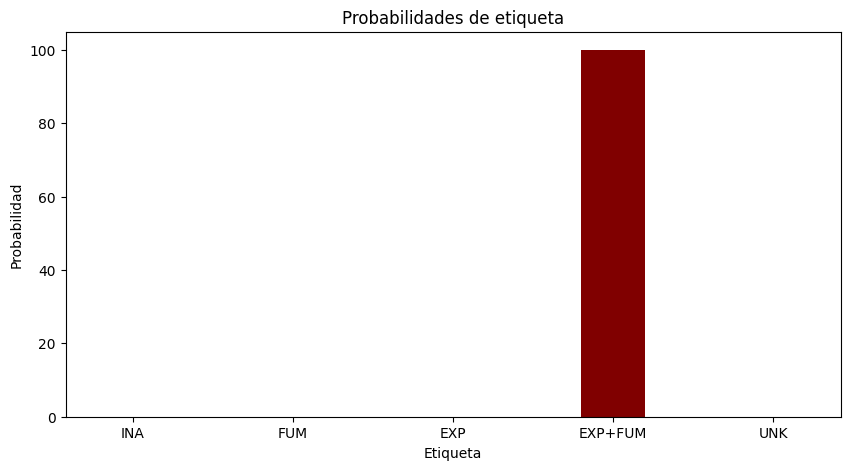

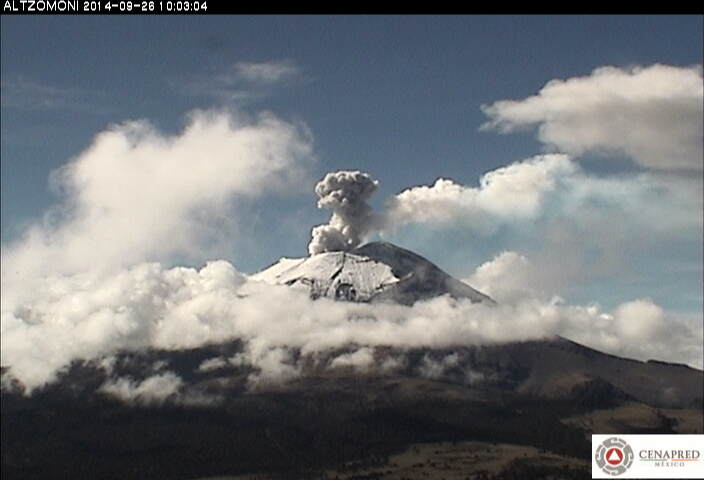

In [47]:
idx=np.random.choice(len(Data["test"]))

row=Data["test"][idx]

inputs = image_processor(images=row["image"], return_tensors="pt")["pixel_values"].to("cuda")
outputs = model(pixel_values=inputs)
logits = outputs.logits
#logits=model(**inputs).logits
#print("LOGITS:",logits)

probabilities = nn.functional.softmax(logits, dim=-1)
probabilities = probabilities.detach().cpu().numpy().flatten()
print("PROBABILIDADES:",probabilities)
print("LA SUMA",probabilities.sum())
print(model.config.label2id)

predicted_class_idx = logits.argmax(-1).item()
print("Predicted class:", model.config.id2label[predicted_class_idx])
print("Real class:",model.config.id2label[row["label"]])
#print(probabilities*100)
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (10, 5))
display_labels=["INA","FUM","EXP","EXP+FUM","UNK"]
# creating the bar plot
plt.bar(display_labels, [probabilities[model.config.label2id[x]]*100 for x in display_labels], color ='maroon', width = 0.4)
 
plt.xlabel("Etiqueta")
plt.ylabel("Probabilidad")
plt.title("Probabilidades de etiqueta")
plt.show()
row["image"]

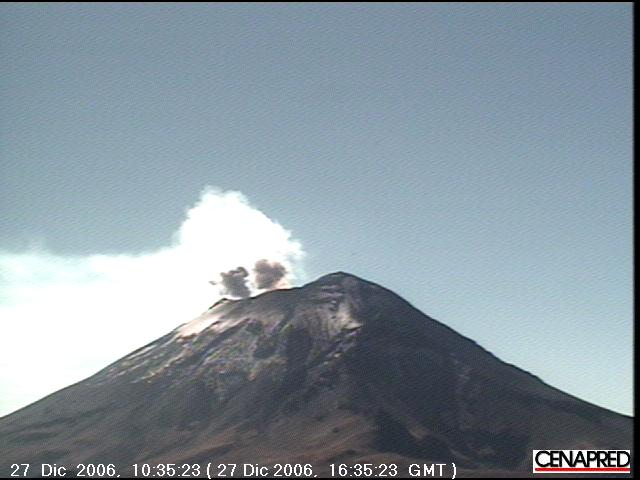

In [48]:
Data["train"][0]["image"]

In [49]:
model_misclassifications=[]
from fastprogress import progress_bar as pb

for i,data_point in enumerate(pb(Data["train"])):
    error=None
    
    try:
        inputs = image_processor(images=data_point["image"], return_tensors="pt")["pixel_values"].to("cuda")
        logits = model(pixel_values=inputs).logits
        probabilities = nn.functional.softmax(logits, dim=-1)
        probabilities = probabilities.detach().cpu().numpy().flatten()
        predicted_class_idx = logits.argmax(-1).item()
        real_class_idx=data_point["label"]
    except Exception as e:
        error=str(e)
    if error:
        model_misclassifications.append(pd.Series([i, model.config.id2label[real_class_idx], -1, real_class_idx, -1, 0]))
    elif(predicted_class_idx!=real_class_idx):
        certainty=round(probabilities[predicted_class_idx]*100,2)
        model_misclassifications.append(pd.Series([i, model.config.id2label[real_class_idx], model.config.id2label[predicted_class_idx], real_class_idx,predicted_class_idx,certainty]))
    i+=1

In [70]:
len(model_misclassifications)/len(Data["train"])*100

4.542835190165194

In [51]:
model_misclassifications_df=pd.concat(model_misclassifications, join="inner", axis=1, ignore_index=True).T
model_misclassifications_df.columns=["ID","RealClass","PredictedClass","RealClassID","PredictedClassID","Certainty"]
model_misclassifications_df.sort_values(by="Certainty", ascending=False,inplace=True)

In [52]:
model_misclassifications_df.shape

(946, 6)

In [61]:
realID=[]
for i in range(model_misclassifications_df.shape[0]):
    realID.append(Data["train"][model_misclassifications_df.iloc[i,0]]["orig_id"])
model_misclassifications_df["RealID"]=realID

In [62]:
model_misclassifications_df.head(50)

,ID,RealClass,PredictedClass,RealClassID,PredictedClassID,Certainty,RealID
92,1843,FUM,EXP+FUM,2,3,100.0,9577
895,19638,FUM,EXP+FUM,2,3,100.0,18857
355,7388,UNK,FUM,0,2,100.0,11721
51,1027,EXP,EXP+FUM,1,3,100.0,18854
907,19858,EXP+FUM,FUM,3,2,100.0,9338
606,13140,UNK,FUM,0,2,100.0,4340
878,19280,EXP+FUM,FUM,3,2,99.99,16143
501,10894,INA,FUM,4,2,99.99,21376
581,12748,INA,FUM,4,2,99.99,95
449,9731,FUM,EXP+FUM,2,3,99.99,5508


In [63]:
model_misclassifications_df.to_csv("model_misclassifications.csv")

In [65]:
model_misclassifications_df.iloc[0]

ID                     1843
RealClass               FUM
PredictedClass      EXP+FUM
RealClassID               2
PredictedClassID          3
Certainty             100.0
RealID                 9577
Name: 92, dtype: object